In [1]:
# Import necessary libraries
import math
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

import tifffile
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.graph_objects as go

In [2]:
# Folder navigation for batch processing
def find_files(base_dir, folder_pattern, file_pattern):
    matched_files = []
    for folderpath, dirnames, filenames in os.walk(base_dir):
        if folder_pattern in os.path.basename(folderpath):
            for filename in filenames:
                if file_pattern in filename and filename.endswith('.csv'):
                    matched_files.append(os.path.join(folderpath, filename))
    return matched_files

def extract_sample_index(filename):
    match = re.search(r'sample(\d+)', filename)
    return match.group(1) if match else None

In [3]:
# Calculate distances between the union of k nearest neighbor effectors to targets, k nearest neighbor targets to effectors
def bidirectional_knn_distances(target_path, effector_path, sample_idx, output_folder, k=50):
    '''
    Parameters: target_spots path
                effector_spots path
                sample index
                path to where the distance matrices is to be saved
                number of nearest neighbors to include
    
    Returns: pivoted distance master file
    '''
    # Load spots.csv files
    target_df = pd.read_csv(target_path)
    effector_df = pd.read_csv(effector_path)
    effector_df.drop([0,1,2], axis=0, inplace=True) # Remove duplicated column names in from TrackMate's output
    effector_df = effector_df.reset_index()

    # Cleanup data
    effector_df['POSITION_X'] = pd.to_numeric(effector_df['POSITION_X'], errors='coerce')
    effector_df['POSITION_Y'] = pd.to_numeric(effector_df['POSITION_Y'], errors='coerce')
    effector_df['TRACK_ID'] = pd.to_numeric(effector_df['TRACK_ID'], errors='coerce')
    effector_df['FRAME'] = pd.to_numeric(effector_df['FRAME'], errors='coerce')

    # Drop rows where conversion failed (i.e., invalid entries became NaN)
    effector_df.dropna(subset=['POSITION_X', 'POSITION_Y', 'TRACK_ID', 'FRAME'], inplace=True)
    
    all_distances = []

    for frame in sorted(set(target_df['Frame']).intersection(set(effector_df['FRAME']))):
        target_frame = target_df[target_df['Frame'] == frame]
        effector_frame = effector_df[effector_df['FRAME'] == frame]

        target_coords = target_frame[['POSITION_X', 'POSITION_Y']].values
        effector_coords = effector_frame[['POSITION_X', 'POSITION_Y']].values
        target_ids = target_frame['target_ID'].values
        effector_ids = effector_frame['TRACK_ID'].values

        if len(target_coords) == 0 or len(effector_coords) == 0:
            continue

        # Target to Effector
        nbrs_t2e = NearestNeighbors(n_neighbors=min(k, len(effector_coords))).fit(effector_coords)
        distances_t2e, indices_t2e = nbrs_t2e.kneighbors(target_coords)
        for i, (dists, idxs) in enumerate(zip(distances_t2e, indices_t2e)):
            for dist, idx in zip(dists, idxs):
                all_distances.append({
                    'Frame': frame,
                    'target_ID': target_ids[i],
                    'effector_ID': effector_ids[idx],
                    'Distance': dist
                })

        # Effector to Target
        nbrs_e2t = NearestNeighbors(n_neighbors=min(k, len(target_coords))).fit(target_coords)
        distances_e2t, indices_e2t = nbrs_e2t.kneighbors(effector_coords)
        for i, (dists, idxs) in enumerate(zip(distances_e2t, indices_e2t)):
            for dist, idx in zip(dists, idxs):
                all_distances.append({
                    'Frame': frame,
                    'target_ID': target_ids[idx],
                    'effector_ID': effector_ids[i],
                    'Distance': dist
                })

    # Combine and remove duplicates (if any)
    distance_df = pd.DataFrame(all_distances).drop_duplicates()
    # Pivot the DataFrame for ease of downstream analysis
    distance_pivot_df = distance_df.pivot_table(index=['target_ID', 'effector_ID'], columns='Frame', values='Distance')
    # Save the pivoted DataFrame for visualization
    distance_pivot_df.to_csv(os.path.join(output_folder, f'sample{sample_idx}_pivoted_distances.csv'))
    
    return distance_pivot_df

In [4]:
# Filter distance_pivot_df such that pairs where there is no NaN in N+1 consecutive frames is being retained
def has_valid_consecutive_values(row, N):
    # Convert to boolean mask: True where value is not NaN
    not_nan = row.notna().values.astype(int)
    
    # Use convolution to find stretches of N+1 consecutive non-NaNs
    window = np.ones(N + 1, dtype=int)
    valid_runs = np.convolve(not_nan, window, mode='valid')
    
    return np.any(valid_runs == (N + 1))

def filter_pairs_with_consecutive_non_nan(df, N):
    # Apply the check row-wise
    return df[df.apply(lambda row: has_valid_consecutive_values(row, N), axis=1)]

In [5]:
# Merge overlapping or consecutive (Start_Frame, End_Frame) intervals for the same (target_ID, effector_ID) pair.
def merge_overlapping_intervals(df):
    merged_rows = []

    # Group by target_ID and effector_ID
    for (target_id, effector_id), group in df.groupby(['target_ID', 'effector_ID']):
        # Sort intervals by Start_Frame
        intervals = group.sort_values('Start_Frame')[['Start_Frame', 'End_Frame']].values

        # Merge overlapping or consecutive intervals
        merged = []
        current_start, current_end = intervals[0]
        for start, end in intervals[1:]:
            if start <= current_end + 1:  # overlap or consecutive
                current_end = max(current_end, end)
            else:
                merged.append((target_id, effector_id, current_start, current_end))
                current_start, current_end = start, end
        merged.append((target_id, effector_id, current_start, current_end))  # final one

        merged_rows.extend(merged)

    return pd.DataFrame(merged_rows, columns=['target_ID', 'effector_ID', 'Start_Frame', 'End_Frame'])

In [6]:
# Identify object pairs where the distance decreases over N consecutive frames
def find_approaching_pairs(distance_df, N, sample_idx, output_folder):
    '''
    Parameters: pivoted distance DataFrame, N number of consecutive frames, sample index, output folder path
    Returns: DataFrame with columns: target_ID, effector_ID, Start_Frame, End_Frame
    '''
    approaching_pairs = []

    # Filter data
    filtered = filter_pairs_with_consecutive_non_nan(distance_df, N)

    for (obj1, obj2), row in filtered.iterrows():
        data = row.values
        idxs = np.arange(len(data))
        # Build N-window "differences" matrix
        # Get all rolling windows of size N+1
        if len(data) < N+1 or np.sum(~np.isnan(data)) < N+1:
            continue
        sliding = np.lib.stride_tricks.sliding_window_view(data, N+1)
        valid = ~np.isnan(sliding).any(axis=1)
        diffs = np.diff(sliding, axis=1)
        # Each row: need all diffs negative (strictly decreasing)
        is_dec = (diffs < 0).all(axis=1)
        matches = np.where(valid & is_dec)[0]
        for m in matches:
            # The window starts at index m, ends at m+N
            start_frame = row.index[m]
            end_frame = row.index[m+N]
            approaching_pairs.append((obj1, obj2, start_frame, end_frame))

    # Save results to CSV
    result_df = pd.DataFrame(approaching_pairs,
                             columns=['target_ID', 'effector_ID', 'Start_Frame', 'End_Frame'])
    result_merged = merge_overlapping_intervals(result_df)
    result_merged.to_csv(os.path.join(output_folder, f'sample{sample_idx}_approaching_pairs.csv'), index=False)
    
    return result_df

In [7]:
# Identify object pairs where the distance stays below a threshold for N consecutive frames
def find_persistent_contact(distance_df, threshold, N, sample_idx, output_folder):
    '''
    Parameters: pivoted distance DataFrame, distance threshold, N number of consecutive frames, sample index, output folder path
    Returns: DataFrame with columns: target_ID, effector_ID, Start_Frame, End_Frame
    '''
    persistent_contact_pairs = []

    # Filter data
    filtered = filter_pairs_with_consecutive_non_nan(distance_df, N)

    for (obj1, obj2), row in filtered.iterrows():
        # row is a Series (frame-indexed)
        mask = row < threshold           # boolean mask: true where under threshold
        mask = mask & row.notna()        # only consider non-NaN
        # Rolling sum, window=N, tells you where there are N consecutive True
        roll = mask.rolling(window=N, min_periods=N).sum()
        hits = roll[roll == N]
        if not hits.empty:
            hit_idxs = list(hits.index)
            for end_frame in hit_idxs:
                start_frame = row.index[row.index.get_loc(end_frame) - N + 1]
                persistent_contact_pairs.append((obj1, obj2, start_frame, end_frame))

    # Save results to CSV
    result_df = pd.DataFrame(
        persistent_contact_pairs,
        columns=['target_ID', 'effector_ID', 'Start_Frame', 'End_Frame']
    )
    result_merged = merge_overlapping_intervals(result_df)
    result_merged.to_csv(os.path.join(output_folder, f'sample{sample_idx}_persistent_contact_pairs.csv'), index=False)
    
    return result_df

In [8]:
# Count the occurrences of: targets that appeared in the interaction (approaching or persistent) DataFrame, effectors that were paired with those targets
def count_occurrences(target_ids, interaction_df):
    '''
    Parameters: ID list of targets, interaction (approaching or persistent contact) DataFrame
    Returns: DataFrame with the number of occurrences for each given target ID  
    '''
    # Filter interaction_df for rows where 'target_ID' is in target_ids
    filtered_hits = interaction_df[interaction_df['target_ID'].isin(target_ids)]

    # Count occurrences of each target ID appears among those interactions
    target_occurrence_counts = filtered_hits['target_ID'].value_counts().reset_index()
    target_occurrence_counts.columns = ['target_ID', 'Occurrences']

    return target_occurrence_counts

In [9]:
# Sample DataFrame pre-processing for graphing
def df_preprocessing(sample_idx, target_df, combined_target, persistent_df, combined_persistent, frame_interval=5):
    # Persistent contact DataFrame pre-processing
    # Convert frame number to time
    persistent_df['Duration'] = (persistent_df['End_Frame'] - persistent_df['Start_Frame']) * frame_interval
    persistent_df['Start_Time'] = persistent_df['Start_Frame'] * frame_interval
    persistent_df['End_Time'] = persistent_df['End_Frame'] * frame_interval
    target_df['Time'] = target_df['Frame'] * frame_interval
    target_df['Death_Time'] = target_df['Death_Frame'] * frame_interval

    # Add terminal state, transition frame, leakage count information to the contact dataframe
    target_sorted = target_df.sort_values('Frame', ascending=False)
    target_summary = target_sorted[['target_ID', 'Target_State', 'Death_Frame', 'Death_Time', 'Leakage_Count']].drop_duplicates(subset=['target_ID'], keep='first')

    for col in ['Target_State', 'Death_Frame', 'Death_Time', 'Leakage_Count']:
        persistent_df[col] = persistent_df['target_ID'].map(target_summary.set_index('target_ID')[col])
    
    # Count occurrences of all targets in persistent interaction DataFrame
    target_occurrences = count_occurrences(target_summary['target_ID'], persistent_df)
    # Map number of occurrences into persistent interaction DataFrame
    id_to_count = target_occurrences.set_index("target_ID")["Occurrences"]
    persistent_df['Interaction_Count'] = persistent_df['target_ID'].map(id_to_count)

    # Assign bins based on number of persistent contacts for each target
    bins = [0, 3, 6, 9, float('inf')]
    labels = ['1-3', '4-6', '6-9', '>9']
    persistent_df['Interaction_Group'] = pd.cut(persistent_df['Interaction_Count'], bins=bins, labels=labels)

    # Compute total interaction duration per target
    total_duration_df = (
        persistent_df.groupby("target_ID")["Duration"]
        .sum()
        .reset_index(name="Cumulative_Duration")
    )
    persistent_df = pd.merge(persistent_df, total_duration_df, on="target_ID")
    
    # Concatenate target_df, persistent_df for visualizing killing kinetics by sample
    target_df['Sample'] = f'sample{sample_idx}'
    combined_target.append(target_df)
    persistent_df['Sample'] = f'sample{sample_idx}'
    combined_persistent.append(persistent_df)

    # Drop duplicated
    persistent_sorted = persistent_df.sort_values('Start_Frame', ascending=False)
    persistent_summary = persistent_sorted.drop_duplicates(subset=['target_ID'], keep='first')

    return persistent_df, combined_persistent, target_df, combined_target, persistent_summary, target_summary

In [10]:
# Plot histograms of interactions count and interaction time distribution
def plot_histogram_interaction_distribution(sample_idx, persistent_df, target_summary, fig_folder):
    fig, axes = plt.subplots(2, 2, figsize=(16, 6))
    # Plot 1
    # Manually set histogram bins and x-axis ticks
    plot1_max_target = persistent_df["Interaction_Count"].max()
    plot1_bins = np.arange(0.5, plot1_max_target + 1.5, 1)
    plot1_x_ticks = np.arange(1, plot1_max_target + 1)

    # Plot data
    sns.histplot(
        data=persistent_df, 
        x='Interaction_Count',
        hue="Target_State", 
        hue_order = ["alive", "dead"],
        multiple="dodge",
        shrink=0.8,
        bins=plot1_bins, 
        color='steelblue', 
        ax=axes[0,0]
    )
    axes[0,0].set_title(f'Sample{sample_idx} Persistent encountered before target death')
    axes[0,0].set_xlabel('Number of persistent contact')
    axes[0,0].set_ylabel('Number of Targets')
    axes[0,0].set_xticks(plot1_x_ticks)
    axes[0,0].yaxis.set_major_locator(MaxNLocator(integer=True)) # force y-axis ticks to be integers
    axes[0,0].grid(True, linestyle='--', alpha=0.4)
    state_legend = axes[0,0].get_legend()
    state_legend.set_title('State of Target')

    
    # Plot 2
    # Manually set histogram bins and x-axis ticks
    plot2_max_duration = persistent_df['Duration'].max()
    plot2_bin_edges = np.arange(0, plot2_max_duration + 10, 10)

    # Plot data
    sns.histplot(
        data=persistent_df, 
        x="Duration", 
        hue="Target_State", 
        hue_order = ["alive", "dead"],
        multiple="dodge",
        shrink=0.8,
        bins=plot2_bin_edges,
        palette = "tab10", 
        element = "bars", # "bars" or "step"
        ax=axes[0,1]
    )
    axes[0,1].set_title(f"Sample{sample_idx} Persitent Contact Duration by Target Fate")
    axes[0,1].set_xlabel("Persistent contact duration (minutes)")
    axes[0,1].set_xticks(np.arange(0, plot2_max_duration + 20, 20))
    axes[0,1].set_ylabel("Number of persistent contacts")
    axes[0,1].grid(axis='y', linestyle='--', alpha=0.6)
    state_legend = axes[0,1].get_legend()
    state_legend.set_title('State of Target')

    
    # Plot 3
    # Manually set histogram bins and x-axis ticks
    plot3_max_duration = persistent_df['Cumulative_Duration'].max()
    plot3_bin_edges = np.arange(0, plot3_max_duration + 20, 20)
    
    sns.histplot(
        data=persistent_df,
        x="Cumulative_Duration",
        hue="Interaction_Group",
        bins=plot3_bin_edges,
        multiple="stack",  # "stack" or "dodge" or "layer"
        kde = True,
        palette="Set2",
        edgecolor="black",
        ax = axes[1,0]
    )
    axes[1,0].set_title(f"Sample{sample_idx} Cumulative Persistent Contact Duration Split by Number of Contacts per Target")
    axes[1,0].set_xlabel("Cumulative persistent contact duration (min)")
    axes[1,0].set_xticks(np.arange(0, plot3_max_duration + 50, 50))
    axes[1,0].set_ylabel("Number of persistent contacts")
    axes[1,0].grid(axis='y', linestyle='--', alpha=0.6)
    interaction_legend = axes[1,0].get_legend()
    interaction_legend.set_title('Persistent Contact per Target')


    # Plot 4
    # Manually set histogram bins and x-axis ticks
    plot4_max_leak = target_summary["Leakage_Count"].max()
    plot4_bins = np.arange(-0.5, plot4_max_leak + 1.5, 1)
    plot4_x_ticks = np.arange(0, plot4_max_leak + 1)
    
    sns.histplot(
    data=target_summary,
        x='Leakage_Count',
        hue='Target_State',
        hue_order = ["alive", "dead"],
        multiple='dodge',  # bars side by side
        shrink=0.8,
        bins=plot4_bins,
        ax = axes[1,1]
    )
    axes[1,1].set_title("Leakage Count Distribution by Target Fate")
    axes[1,1].set_xlabel("Leakage event count per cell")
    axes[1,1].set_xticks(plot4_x_ticks)
    axes[1,1].set_ylabel("Number of target cells")
    state_legend = axes[1,1].get_legend()
    state_legend.set_title('State of Target')

    plt.tight_layout()
    
    # Save figure
    # fig_path = os.path.join(fig_folder, f"xy{sample_idx}_interaction_distribution_histograms.png")
    # fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    
    plt.show()

In [20]:
# Plot leakage heatmap (with effector-target interaction overlaid)
def draw_triangle(ax, col, row, color='gold', alpha=0.7, orientation='up'):
    """
    Draw a triangle at the specified cell block (col, row).
    orientation: 'up', 'down', 'left', 'right'
    """
    # Coordinates for the center of the block
    x0, y0 = col, row
    # Vertices for 'up' triangle in block [x0, x0+1], [y0, y0+1]
    if orientation == 'up':
        triangle = [
            (x0+0.1, y0+0.9),
            (x0+0.9, y0+0.9),
            (x0+0.5, y0+0.1)
        ]
    elif orientation == 'down':
        triangle = [
            (x0+0.1, y0+0.1),
            (x0+0.9, y0+0.1),
            (x0+0.5, y0+0.9)
        ]
    elif orientation == 'left':
        triangle = [
            (x0+0.1, y0+0.1),
            (x0+0.1, y0+0.9),
            (x0+0.9, y0+0.5)
        ]
    elif orientation == 'right':
        triangle = [
            (x0+0.9, y0+0.1),
            (x0+0.9, y0+0.9),
            (x0+0.1, y0+0.5)
        ]
    _ = ax.add_patch(plt.Polygon(triangle, fc=color, alpha=alpha, ec=None))


def plot_leakage_heatmap(leakage_df, persistent_df, fig_folder):
    # Step 1: Build event matrix
    # Filter TRACK_IDs with at least one frame where leakage occurred
    leaky_cells = leakage_df.query("Leakage_Count > 0")['target_ID'].unique()
    leaky_df = leakage_df[leakage_df['target_ID'].isin(leaky_cells)]

    # Get full range of time
    all_times = np.sort(leaky_df['Time'].unique())
    
    # For each leaky cell, build a complete row for all frames
    event_matrix = []
    cell_order  = []
    for tid, subdf in leaky_df.groupby('target_ID'):
        times_this_cell = set(subdf['Time'])
        event_row = []
        for t in all_times:
            if t in times_this_cell:
                event = subdf.loc[subdf['Time']==t, 'Leakage']
                val = 1 if event.any() else 0
            else:
                val = -1  # Cell not present
            event_row.append(val)
        event_matrix.append(event_row)
        cell_order.append(tid)
    event_matrix = np.array(event_matrix)
    
    # Sort rows by time of first leakage (leftmost leak)
    first_leak = (event_matrix == 1).argmax(axis=1)
    sort_order = np.argsort(first_leak)
    event_matrix = event_matrix[sort_order,:]
    cell_order = [cell_order[i] for i in sort_order] # reorder

    
    # Step 2: Plot heatmap
    # Create colormap: colors = gray (absent), blue (present/no leak), magenta (leak)
    cmap = ListedColormap(['#aaaaaa', '#222266', '#d13d85'])  # -1, 0, 1
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    # pcolor wants the *edge* coordinates, so pad axes by 1.
    # Also, pcolor plots (row=0, col=0) in lower left, so flip Y if top-down is needed
    to_plot = event_matrix  # shape (n_cells, n_times)
    n_cells, n_times = to_plot.shape
    # Create 'edges' for axes
    x_edges = np.arange(n_times + 1)
    y_edges = np.arange(n_cells + 1)

    # Plotting
    pc = ax.pcolor(x_edges, y_edges, to_plot, cmap=cmap, norm=norm, edgecolors='k', linewidth=0.5)
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Target cell')
    
    # Set x-axis ticks
    tick_locs = np.arange(n_times) + 0.5   # center of each pcolor block
    interval = max(1, n_times // 10)  # Show about ticks at intervals of 20 (for clarity)
    xticks_to_show = np.arange(0, n_times, interval)
    plt_xticklabels = [f"{all_times[i]:d}" for i in xticks_to_show]  
    ax.set_xticks(tick_locs[xticks_to_show])
    ax.set_xticklabels(plt_xticklabels, rotation=45)
    
    # Hide y-axis ticks and tick labels
    ax.tick_params(axis='y', left=False, labelleft=False) 
    ax.set_title('Target Cell Leakage Heatmap')


    # Step 3: Overlay effector-target interaction
    # Map TRACK_IDs to row indices (matching event_matrix order)
    trackid_to_row = {tid: i for i, tid in enumerate(cell_order)}
    time_to_col = {t: j for j, t in enumerate(all_times)}
    
    for _, row in persistent_df.iterrows():
        tid = row['target_ID']
        if tid not in trackid_to_row:
            # NOTE: we may want to add a count for contacted but not leaked cells
            continue  # skip interactions for unplotted cells
        row_idx = trackid_to_row[tid]
    
        # For every frame in interaction interval
        for t in all_times:
            if row['Start_Time'] <= t <= row['End_Time']:
                col_idx = time_to_col[t]
                draw_triangle(ax, col_idx, row_idx, color='gold', alpha=0.8, orientation='up')
    
    plt.tight_layout()
    # Save figure
    # fig_path = os.path.join(fig_folder, f"xy{sample_idx}_interaction_distribution_histograms.png")
    # fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()

In [12]:
# Plot box plot for distribution of time from leakage to death
def plot_lag_time_box_plot(combined_target_df, sample_display_names, fig_folder):
    # Pre-processing
    time_to_death_entries = []

    for (sample, tid), group in combined_target_df.groupby(['Sample', 'target_ID']):
        group_sorted = group.sort_values('Time')
        death_time = group_sorted['Death_Time'].iloc[0]  # assume constant for this cell in this sample
    
        leakage_series = group_sorted['Leakage'].astype(int)
        starts = ((leakage_series.diff().fillna(0) == 1) & (leakage_series == 1)).to_numpy()
        leakage_times = group_sorted.loc[starts, 'Time'].values
    
        for event_no, leakage_time in enumerate(leakage_times, 1):
            time_to_death = death_time - leakage_time
            time_to_death_entries.append({
                'Sample': sample,
                'target_ID': tid,
                'leakage_no': event_no,
                'leakage_time': leakage_time,
                'death_time': death_time,
                'time_to_death': time_to_death
            })

    # Create summary DataFrame
    ttd_df = pd.DataFrame(time_to_death_entries)
    ttd_df['Sample_Display'] = ttd_df['Sample'].map(sample_display_names)


    # Plotting
    leak_order = sorted(ttd_df['leakage_no'].unique())
    leak_labels = [f"{i}{'st' if i==1 else 'nd' if i==2 else 'rd' if i==3 else 'th'} leak" for i in leak_order]
    
    plt.figure(figsize=(10, 7))
    sns.boxplot(
        data = ttd_df,
        x='leakage_no',
        y='time_to_death',
        hue='Sample_Display',
        # order=leak_order,
        # hue_order=sorted(ttd_df['Sample_Display'].unique()),
        palette='Set2'
    )
    
    # Change tick labels to match "first leak", "second leak", ...
    plt.xticks(ticks=range(len(leak_order)), labels=leak_labels)
    plt.xlabel('Leakage event number')
    plt.ylabel('Time until death (min)')
    plt.title('Distribution of time-to-death after cell leakage')
    
    plt.legend(title='', bbox_to_anchor=(1, 1))  # Move legend outside if needed
    plt.tight_layout()

    # Save figure
    # fig_path = os.path.join(fig_folder, "area_decay_box_plot.png")
    # plt.savefig(fig_path, dpi=300)

    plt.show()

In [13]:
# Plot % cells that died afer n leaks (and no more), out of all cells that have experienced at least n leaks
def plot_frac_death_vs_leak(combined_target_df, sample_display_names, fig_folder):
    # Pre-processing
    result_list = []
    for sample, df_sample in combined_target_df.groupby('Sample'):
        max_leaks = df_sample['Leakage_Count'].max()
        cell_leak_counts = df_sample.groupby('target_ID')['Leakage_Count'].max()
        
        for n_leaks in range(1, max_leaks + 1):
            # All cells that made it to at least n leaks
            eligible = cell_leak_counts[cell_leak_counts >= n_leaks].index
            n_cells = len(eligible)
            # Among those, cells whose max leakage == n AND that died
            died_with_n = df_sample[
                (df_sample['target_ID'].isin(cell_leak_counts[cell_leak_counts == n_leaks].index)) &
                (df_sample['Target_State'] == 'dead')
            ]['target_ID'].nunique()
            pct_dead = 100 * died_with_n / n_cells if n_cells > 0 else np.nan
            result_list.append({
                'Sample': sample,
                'Leakage_Count': n_leaks,
                'Percent_Dead': pct_dead,
                'N_cells': n_cells
            })
    
    summary_df = pd.DataFrame(result_list)
    summary_df['Sample_Display'] = summary_df['Sample'].map(sample_display_names)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=summary_df,
        x='Leakage_Count',
        y='Percent_Dead',
        hue='Sample_Display',
        marker='o',
        palette='Set2'
    )
    plt.xlabel('Number of leaks experienced (≥ n)')
    plt.ylabel('Percent dead cells (died with n leaks)')
    plt.ylim(0, 105)
    plt.grid(True)
    plt.legend(title="Sample")
    plt.title('Percent of cells dying with n leaks (of all cells reaching ≥ n leaks)')
    plt.tight_layout()

    # Save figure
    # fig_path = os.path.join(fig_folder, "area_decay_box_plot.png")
    # plt.savefig(fig_path, dpi=300)
    
    plt.show()

In [14]:
# Plot % cells that have experienced at least one leakage over time
def plot_leak_over_time(combined_target_df, sample_display_names, fig_folder):
    # Pre-processing
    result_list = []
    for sample, df_sample in combined_target_df.groupby('Sample'):
        # For each target_ID, get the time of first leakage
        first_leak_time = df_sample[df_sample['Leakage']].groupby('target_ID')['Time'].min()
        all_cells = df_sample['target_ID'].unique()
        all_times = np.sort(df_sample['Time'].unique())
        for t in all_times:
            n_leaked = (first_leak_time <= t).sum()
            n_possible = len(all_cells)
            pct = 100 * n_leaked / n_possible if n_possible > 0 else np.nan
            result_list.append({'Sample': sample, 'Time': t, 'Percent_Leaked': pct})
    
    leak_summary_df = pd.DataFrame(result_list)
    leak_summary_df['Sample_Display'] = leak_summary_df['Sample'].map(sample_display_names)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=leak_summary_df, x='Time', y='Percent_Leaked', hue='Sample_Display', palette='Set2')
    plt.xlabel('Time (min)')
    plt.ylabel('% of cells with at least 1 leakage')
    plt.legend(title='Sample')
    plt.title('Cumulative leakage onset kinetics by sample')
    plt.tight_layout()

    # Save figure
    # fig_path = os.path.join(fig_folder, "area_decay_box_plot.png")
    # plt.savefig(fig_path, dpi=300)
    
    plt.show()

In [15]:
# Plot stacked density plot of number of interactions vs. lag time from first interaction to death
def plot_indv_interaction_vs_lag(sample, persistent_df, ax):
    # Find first interaction per target
    first_interaction = (
        persistent_df.groupby('target_ID')['Start_Time']
        .min()
        .rename('First_Interaction_Time')
    )
    
    # Count number of unique effectors per target
    effector_count = (
        persistent_df.groupby('target_ID')['Interaction_Count']
        .first()
        .rename('Interaction_Count')
    )
    
    # Get death frame per target
    death_frame = (
        persistent_df.dropna(subset=["Death_Time"])
        .drop_duplicates("target_ID")[["target_ID", "Death_Time"]]
        .set_index("target_ID")["Death_Time"]
    )
    
    # Combine all info
    summary_df = pd.concat([first_interaction, effector_count, death_frame], axis=1).dropna()
    
    # Compute lag time to death
    summary_df["Lag_to_Death"] = summary_df["Death_Time"] - summary_df["First_Interaction_Time"]
    
    # Plot 2D histogram
    sns.kdeplot(
        data=summary_df,
        x="Lag_to_Death",
        y="Interaction_Count",
        fill=True,
        cmap="mako",
        levels=100,
        thresh=0.01,  # filters low-density regions
        ax = ax
    )
    
    ax.set_xlabel("Lag Time from First Interaction to Death (min)")
    ax.set_ylabel("Total Number of Effectors")
    ax.set_title(f"{sample}")


def plot_panel_interaction_vs_lag(combined_persistent_df, sample_display_names, fig_folder):
    dead_combined_persistent = combined_persistent_df[combined_persistent_df['Target_State'] == 'dead']
    dead_combined_persistent['Sample_Display'] = dead_combined_persistent['Sample'].map(sample_display_names)
    samples = dead_combined_persistent['Sample_Display'].unique()
    n = len(samples)

    fig, axes = plt.subplots(1, n, figsize=(16, 6))
    axes = axes.flatten()  # Make indexing simple

    for i, sample in enumerate(samples):
        persistent_sample = dead_combined_persistent[dead_combined_persistent['Sample_Display'] == sample]
        plot_indv_interaction_vs_lag(sample, persistent_sample, axes[i])

        # Hide unused axes
        for i in range(n, len(axes)):
            fig.delaxes(axes[i])
        
    plt.tight_layout()

    # Save figure
    # fig_path = os.path.join(fig_folder, "interaction_vs_area_decay_histogram.png")
    # fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    
    plt.show()

In [ ]:
# Plot Sankey plot for state transitions
def plot_sankey(sample_idx, spots_df, area_df, fig_folder, shrink_threshold=0.7):
    '''
    Parameters: sample index
                spots_df (contains all tracks)
                area_df (contains area over time and death info only of target cells that interacted with effector cells)
    Returns: Sankey plot showing state transitions
    '''
    # Filter sample-specific data
    targets = set(spots_df['TRACK_ID'].unique())
    interacted = set(area_df['TRACK_ID'].unique())
    dead = set(area_df[area_df['Death_Time'].notna()]['TRACK_ID'])

    # Calculate first area per cell
    idx = area_df.groupby('TRACK_ID')['FRAME'].idxmin()
    first_area = area_df.loc[idx].set_index('TRACK_ID')['area'].rename("first_area")
    area_df = area_df.merge(first_area, on="TRACK_ID")

    # Minimum area per cell (to see if it ever dropped below threshold)
    min_area = area_df.groupby('TRACK_ID')['area'].min()
    dropped = set(min_area[min_area < (first_area * shrink_threshold)].index)

    # Categorize cells
    no_interaction = targets - interacted
    interaction_only = interacted - dropped
    shrinking = dropped
    dead_shrinking = shrinking & dead
    alive_shrinking = shrinking - dead

    # Define nodes and flows
    labels = [
        "All Targets",
        "No Interaction", "Interaction",
        "No Shrink", "Shrink",
        "Alive", "Dead"
    ]
    
    sources = [0, 0, 2, 2, 4, 4]  # From node index
    targets = [1, 2, 3, 4, 5, 6]  # To node index
    values = [
        len(no_interaction),
        len(interacted),
        len(interaction_only),
        len(shrinking),
        len(alive_shrinking),
        len(dead_shrinking)
    ]
    
    # Plot Sankey
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color="lightgray"
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c"]
        )
    )])
    
    fig.update_layout(title_text=f"Target Cell Fate Transitions – xy{sample_idx}", font_size=12)

    # Save figure
    fig_path = os.path.join(fig_folder, f"xy{sample_idx}_Sankey_diagram.png")
    fig.write_image(fig_path, width=800, height=300)
    
    fig.show()

In [ ]:
# Batch calculate distance, approaching pairs, persistent contact
# Provide: master_folder path, number of consecutive frames, threshold distance
master_folder = '/home/vil945/live_cell_imaging/2025-09-30_live_cell_imaging'
N = 3
contact_threshold = 40

# DO NOT change anything beyond this line
# Create output folder
for folderpath, dirnames, filenames in os.walk(master_folder):
    if "metrics" in os.path.basename(folderpath):
        output_master_folder = folderpath
# Match pairs of target ("leakage") tracking files and effector ("effector_spots") files
tracking_files = find_files(master_folder, 'tracking', 'effector_spots')
leakage_files = find_files(master_folder, 'leakage', 'leakage')

# Build dicts mapping sample index -> path
tracking_dict = {extract_sample_index(os.path.basename(f)): f for f in tracking_files}
leakage_dict = {extract_sample_index(os.path.basename(f)): f for f in leakage_files}

matched_pairs = []
for sample_idx in tracking_dict:
    if sample_idx in leakage_dict:
        matched_pairs.append((sample_idx, tracking_dict[sample_idx], leakage_dict[sample_idx]))
    else:
        print(f"Warning: No leakage file for sample{sample_idx}")

# Downstream processing
for sample_idx, tracking_file, leakage_file in matched_pairs:
    print(f"Processing sample{sample_idx}:")
    print(f"  effector file: {tracking_file}")
    print(f"  target file:  {leakage_file}")
    
    output_folder_name = f"sample{sample_idx}_distance_csv_files"
    output_path = os.path.join(output_master_folder, output_folder_name)
    os.makedirs(output_path, exist_ok=True)
    
    distance_pivot_df = bidirectional_knn_distances(leakage_file, tracking_file, sample_idx, output_path, k=20)
    approaching_pairs = find_approaching_pairs(distance_pivot_df, N, sample_idx, output_path) # Call identify approaching pairs function
    persistent_contact_pairs = find_persistent_contact(distance_pivot_df, contact_threshold, N, sample_idx, output_path) # Call identify persistent contact function
            

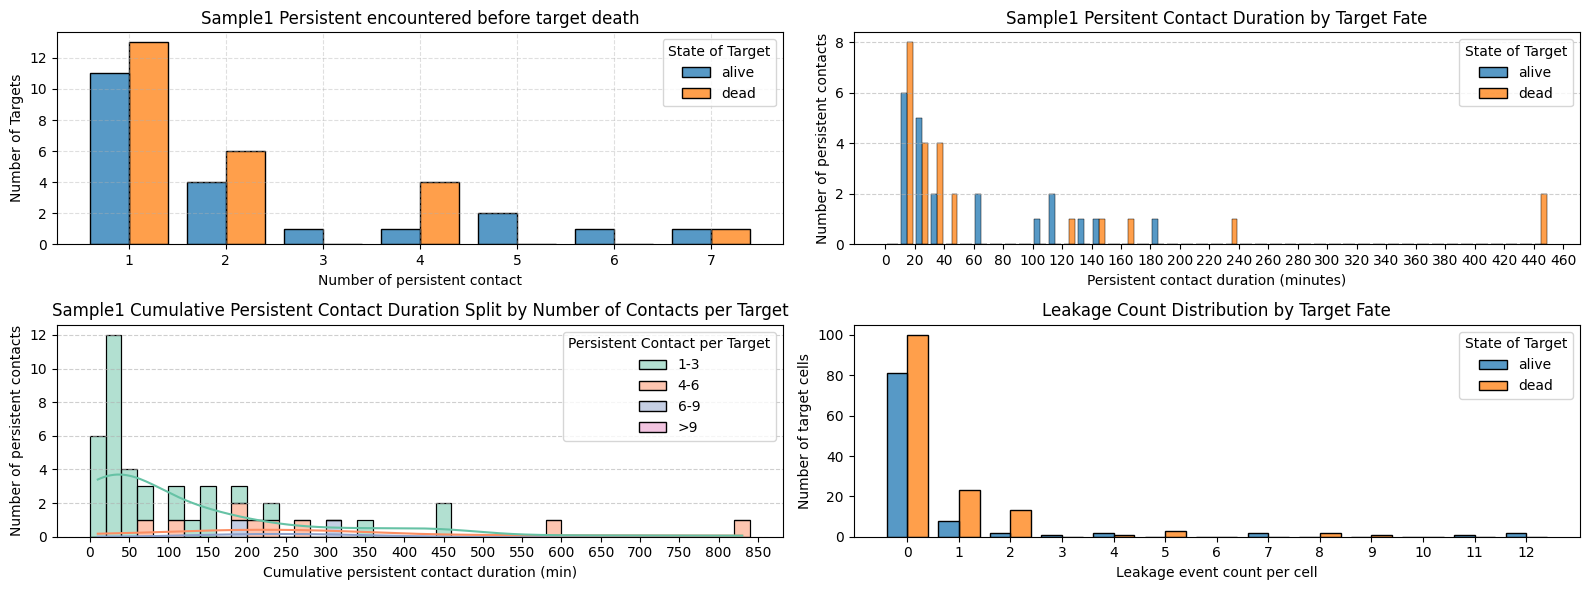

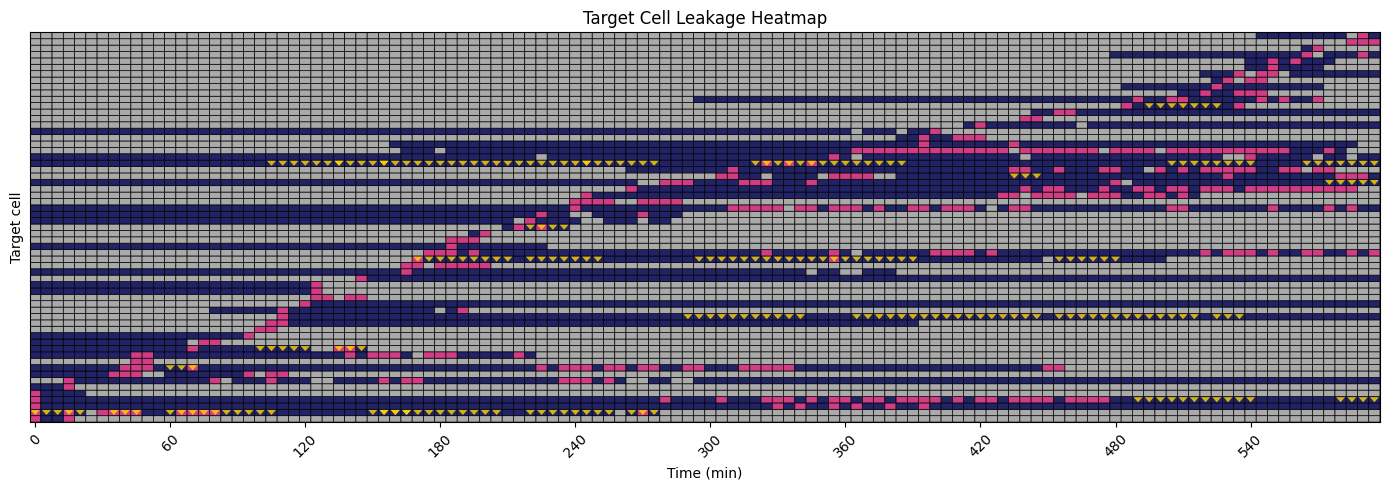

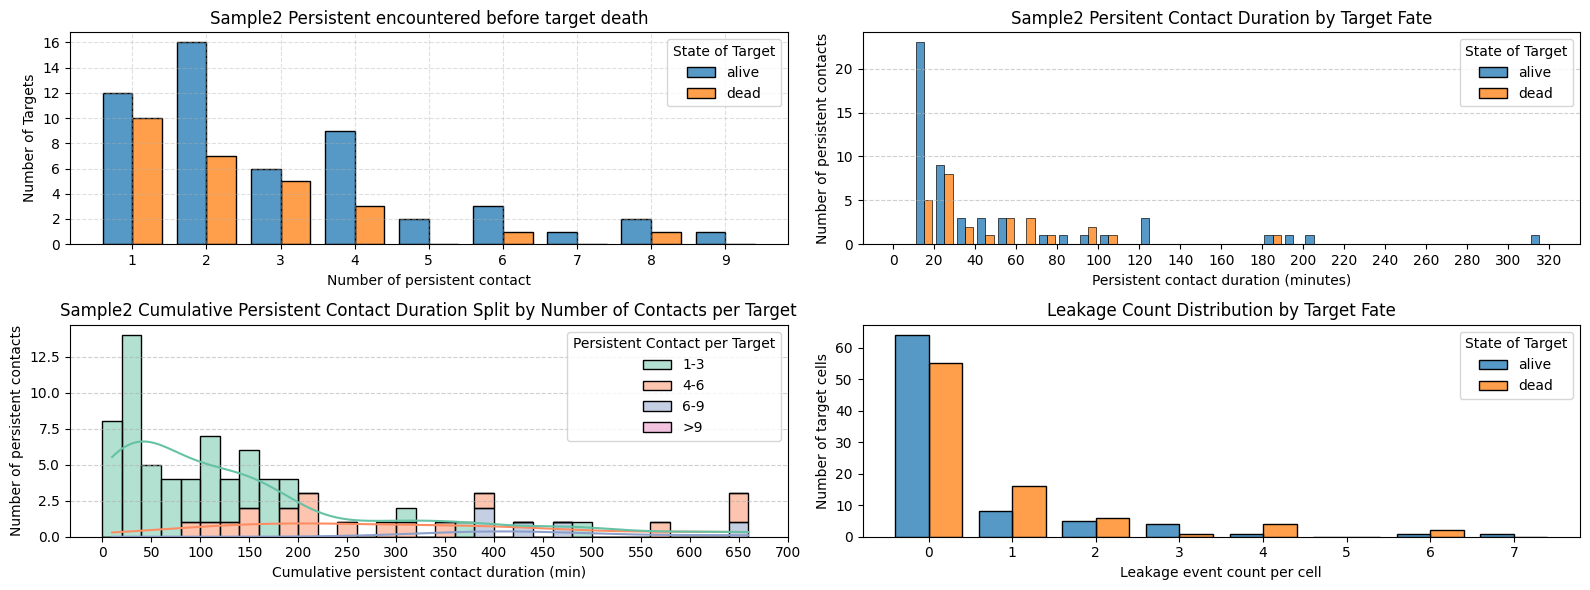

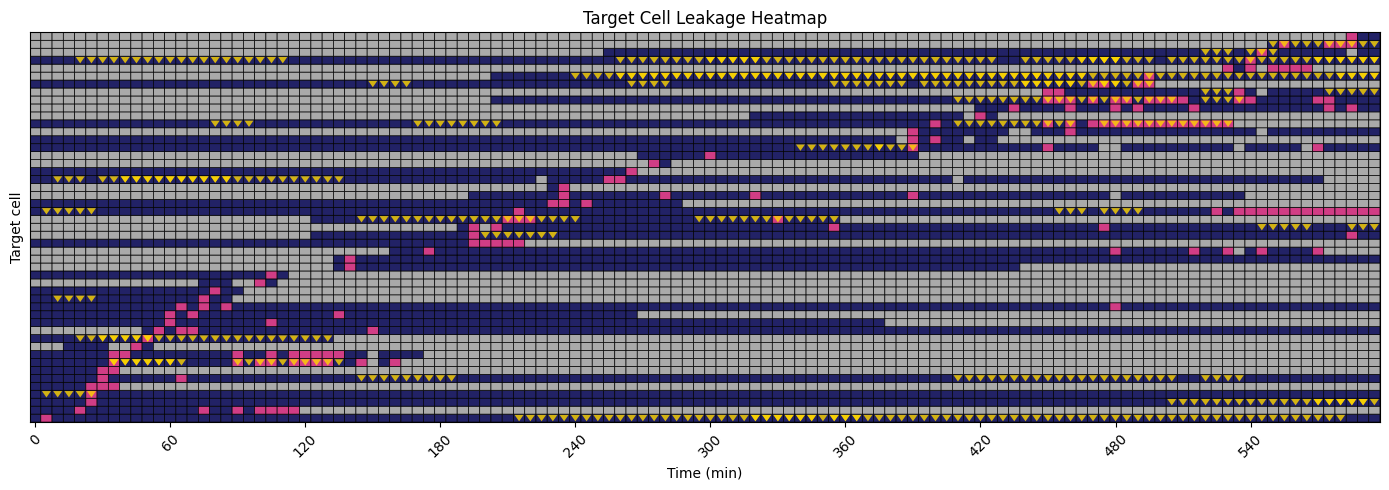

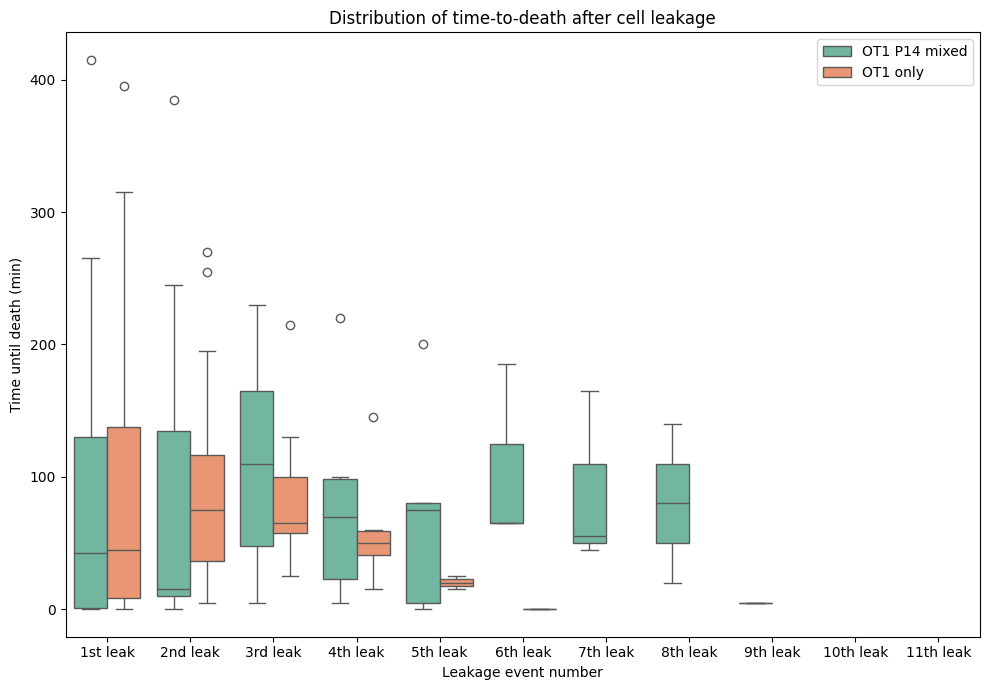

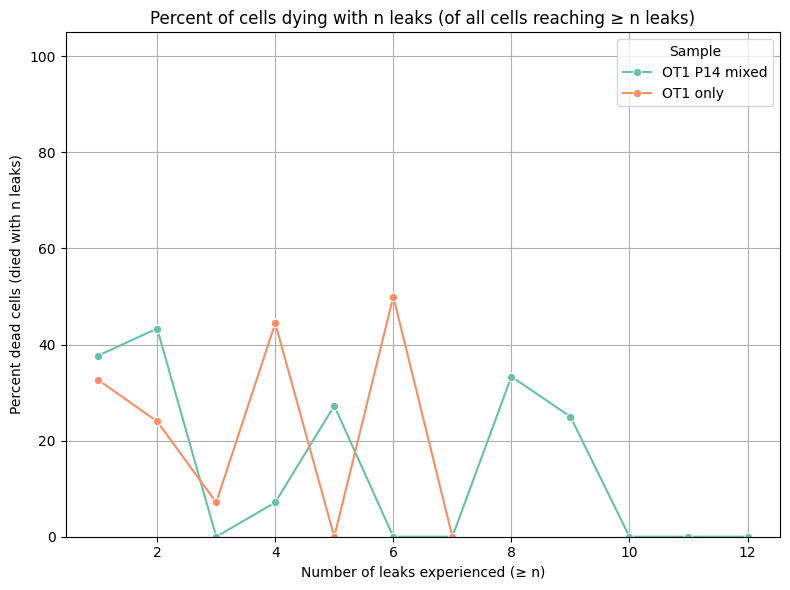

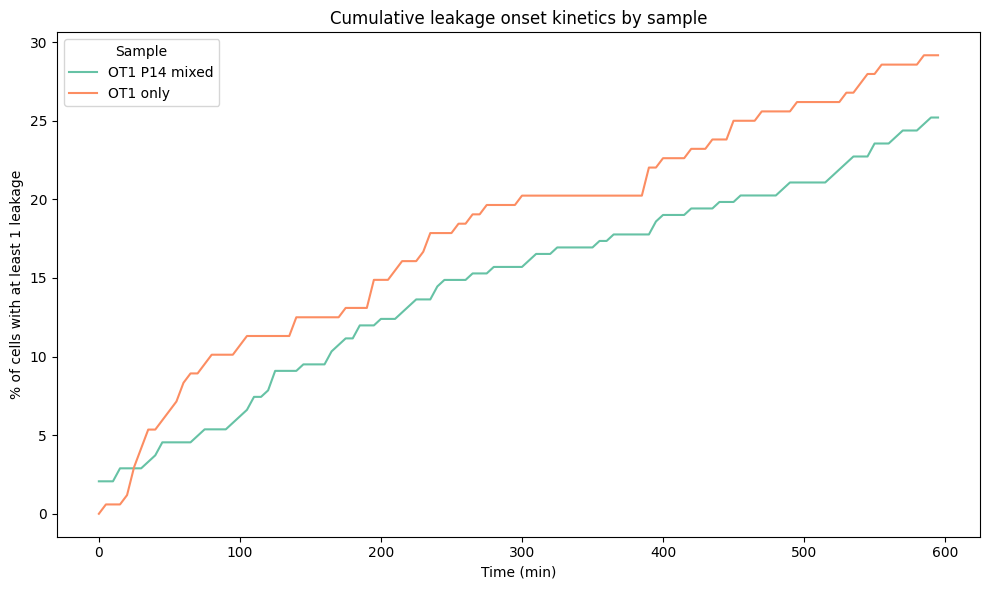

/tmp/ipykernel_791718/2904550472.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dead_combined_persistent['Sample_Display'] = dead_combined_persistent['Sample'].map(sample_display_names)


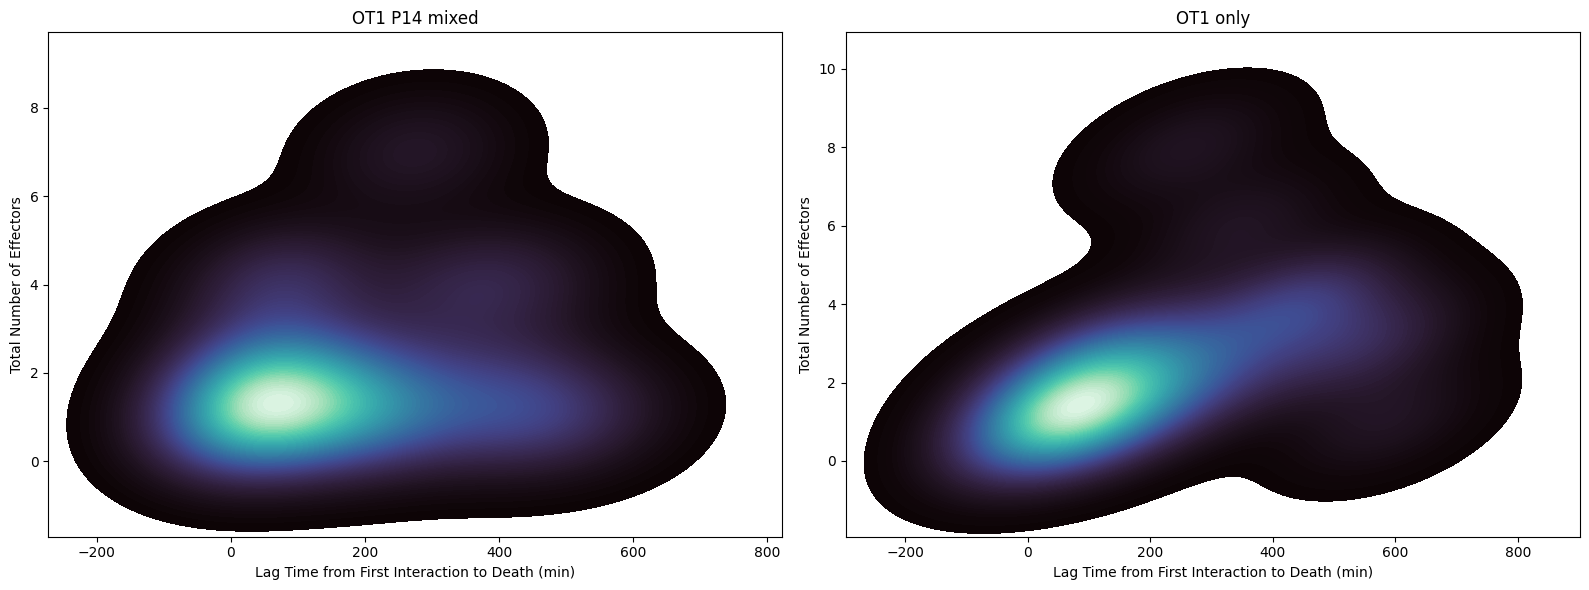

In [21]:
# Batch plot persistent encounter data
master_folder = '/home/vil945/live_cell_imaging/2025-09-30_live_cell_imaging'
# Provide a dictionary for mapping the sample code names to display names
sample_display_names = {
    'sample1': 'OT1 P14 mixed',
    'sample2': 'OT1 only'
}

# DO NOT change anything beyond this line
# Create folder for saving figures
exp_date = re.findall(r'\d{4}-\d{2}-\d{2}', master_folder)[0]
fig_folder = os.path.join(master_folder, f"{exp_date}_figures")
os.makedirs(fig_folder, exist_ok=True)

# Match pairs of target ("leakage") tracking files and effector ("effector_spots") files
contact_files = find_files(master_folder, 'distance', 'persistent')
leakage_files = find_files(master_folder, 'leakage', 'leakage')

# Build dicts mapping sample index -> path
contact_dict = {extract_sample_index(os.path.basename(f)): f for f in contact_files}
leakage_dict = {extract_sample_index(os.path.basename(f)): f for f in leakage_files}

matched_pairs = []
for sample_idx in contact_dict:
    if sample_idx in leakage_dict:
        matched_pairs.append((sample_idx, contact_dict[sample_idx], leakage_dict[sample_idx]))
    else:
        print(f"Warning: No leakage file for sample{sample_idx}")

combined_persistent = []
combined_target = []
# Downstream processing:
for sample_idx, contact_file, leakage_file in matched_pairs:
    # Load DataFrames
    persistent_df = pd.read_csv(contact_file)
    leakage_df = pd.read_csv(leakage_file)

    # Pre-processing
    persistent_df, combined_persistent, target_df, combined_target, persistent_summary, target_summary = df_preprocessing(sample_idx, leakage_df, combined_target, persistent_df, combined_persistent, frame_interval=5)

    # Plot histograms of interaction distribution
    plot_histogram_interaction_distribution(sample_idx, persistent_summary, target_summary, fig_folder)
    plot_leakage_heatmap(target_df, persistent_df, fig_folder)

    
    # Tracking QC/troubleshooting
    # plot_track_length(target_df)

combined_target_df = pd.concat(combined_target, ignore_index=True)
combined_persistent_df = pd.concat(combined_persistent, ignore_index=True)

plot_lag_time_box_plot(combined_target_df, sample_display_names, fig_folder)
plot_frac_death_vs_leak(combined_target_df, sample_display_names, fig_folder)
plot_leak_over_time(combined_target_df, sample_display_names, fig_folder)
plot_panel_interaction_vs_lag(combined_persistent_df, sample_display_names, fig_folder)

In [16]:
def plot_track_length(leakage_df):
    # Get first and last frame for each track
    track_stats = leakage_df.groupby('target_ID')['Frame'].agg(['min', 'max'])
    track_stats['span'] = track_stats['max'] - track_stats['min'] + 1  # inclusive
    track_stats['coverage'] = leakage_df.groupby('target_ID')['Frame'].nunique()
    track_stats['gap_frac'] = 1 - track_stats['coverage'] / track_stats['span']
    
    plt.figure(figsize=(8, 5))
    plt.hist(track_stats['span'], bins=30, color='steelblue', alpha=0.8)
    plt.xlabel('Track length (number of frames)')
    plt.ylabel('Number of target cells')
    plt.title('Distribution of target cell track lengths')
    plt.tight_layout()
    plt.show()